In [1]:
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import multivariate_normal
from scipy.stats import invwishart


df1 = pd.read_csv("clustering_data.csv", header = None).to_numpy()

def sigmoid(x):
  return 1/(1 + np.exp(-x))

# GMM

In [2]:
class GMM:
  def __init__(self, K=1, n_it = 10):
    self.K = K
    self.n_it = n_it

  def fit(self, X):
    k0 = 0.01
    D = X.shape[1]
    media = np.mean(X, axis = 0)
    covariancia = np.cov(X, rowvar = False)
    v0 = D + 2
    S0 = (1 / (self.K ** (2/D))) * covariancia

    self.k0 = k0
    self.m0 = media
    self.v0 = v0
    self.S0 = S0
    self.alfas = np.ones(self.K) / self.K
    self.X = X


  def EM(self):
    X = self.X
    N, D = X.shape
    matcov_medias = np.cov(self.X, rowvar = False)

    pesos = self.alfas

    medias_mist = np.random.multivariate_normal(self.m0, matcov_medias, size=(self.K))
    matcov_mist = np.array([invwishart.rvs(df = 5, scale = matcov_medias) for i in range(self.K)])
    #matcov_mist = np.array([np.eye(D) * 10 for i in range(self.K)])

    #print("MEDIAS:\n",medias_mist)

    # EM
    for _ in range(self.n_it):
      verificar = pd.DataFrame(X)
      P = []
      # PASSO E
      for i in range(self.K):
        distribuicao = multivariate_normal(mean=medias_mist[i], cov=matcov_mist[i])
        p = distribuicao.pdf(X)
        P.append(p)
      P = np.array(P)
      soma_P = P.sum(axis = 0)
      R = []


      for i in range(self.K):
        numerador = pesos[i] * P[i]
        denominador = P.T @ pesos
        rk = numerador / denominador
        R.append( rk )

      R = np.array(R)
      # PASSO M

      novos_pesos = []
      for i in range(self.K):
        novos_pesos.append((self.alfas[i] - 1 + np.sum(R[i])) / (N - self.K + np.sum(self.alfas)))
      pesos = np.array(novos_pesos)

      X_traco = []
      for i in range(self.K):
        var = (R[i] @ X) / np.sum(R[i])
        X_traco.append(var)
      X_traco = np.array(X_traco)

      nova_media_mist = []
      for i in range(self.K):
        var = (self.k0 * self.m0 + X_traco[i] * np.sum(R[i])) / (self.k0 + np.sum(R[i]))
        nova_media_mist.append(var)
      medias_mist = np.array(nova_media_mist)


      nova_matcov_mist = []
      for i in range(self.K):
        dif1 = X - X_traco[i]
        dif2 = X_traco[i] - self.m0
        somatorio1 = np.zeros((2,2))
        for k in range(N):
          somatorio1 = somatorio1 + R[i,k] * (dif1[k].reshape(-1,1) @ dif1[k].reshape(1,-1))
        numerador = self.S0 + somatorio1 + ((self.k0 * np.sum(R[i])) / (self.k0 + np.sum(R[i]))) * (dif2.T @ dif2)
        denominador = self.v0 + D + 2 + np.sum(R[i])
        nova_matcov_mist.append( numerador / denominador )
      matcov_mist = np.array(nova_matcov_mist)

      self.medias = medias_mist
      self.matcovs = matcov_mist

      #print("MEDIAS:\n",medias_mist)




## Função para treino e resultados

In [3]:
def treino_e_resultados(df, K, infos = False):
  X = df
  model = GMM(K = K, n_it = 100)
  model.fit(X)
  model.EM()

  if infos:
    for i in range(model.K):
      print("Media:",model.medias[i])
      print("Matriz de Covariância")
      print(model.matcovs[i])
      print()

  medias = model.medias
  matcovs = model.matcovs

  x_min = min(X[:,0])-1
  x_max = max(X[:,0])+1
  y_min = min(X[:,1])-1
  y_max = max(X[:,1])+1

  x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
  pos = np.dstack((x, y))

  pdfs = []
  for i in range(model.K):
    pdfs.append( multivariate_normal.pdf(pos, mean=medias[i], cov=matcovs[i]) )

  pdfs = np.array(pdfs)
  distrib = np.sum(pdfs, axis = 0)

  plt.contourf(x, y, distrib, cmap='viridis')
  plt.xlabel('Eixo X')
  plt.ylabel('Eixo Y')
  plt.title('Distribuição Preditiva GMM MAP com K = ' + str(K))
  plt.colorbar()

  plt.scatter(X[:,0], X[:,1], c = "black")
  plt.show()

## K = 2

Media: [6.27063643 3.58161607]
Matriz de Covariância
[[ 8.07787646 -1.4748763 ]
 [-1.4748763  13.87339484]]

Media: [-6.8864468  -3.42015091]
Matriz de Covariância
[[ 6.07862214  9.16431057]
 [ 9.16431057 19.68001355]]



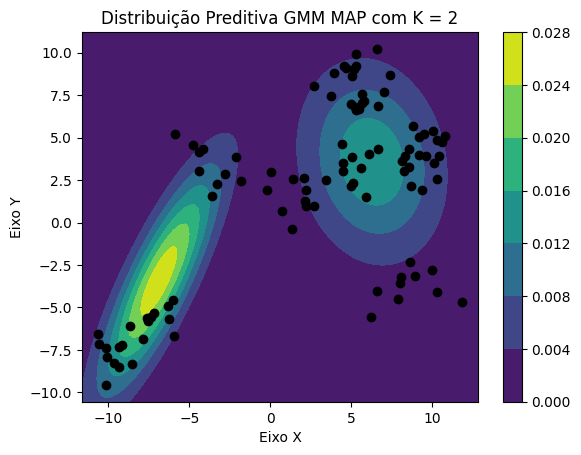

In [9]:
treino_e_resultados(df1, 2, infos = True)

## K = 4

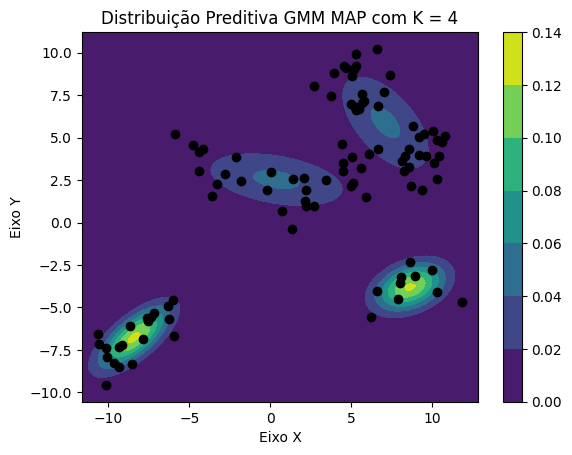

In [12]:
treino_e_resultados(df1, 4)

## K = 6

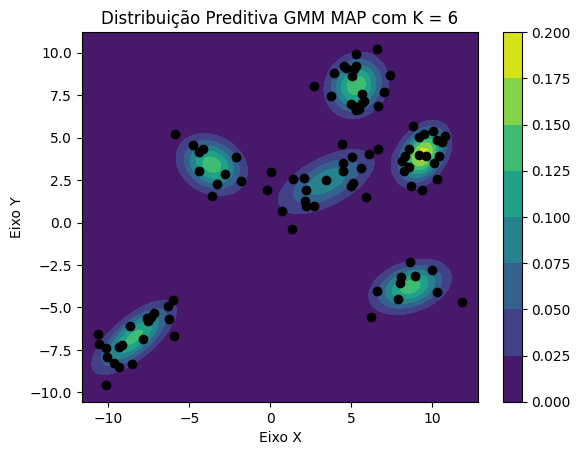

In [6]:
treino_e_resultados(df1, 6)

## K = 8

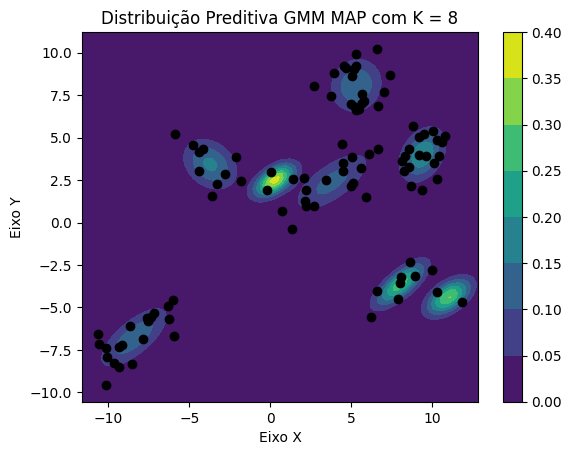

In [13]:
treino_e_resultados(df1, 8)

## K = 10

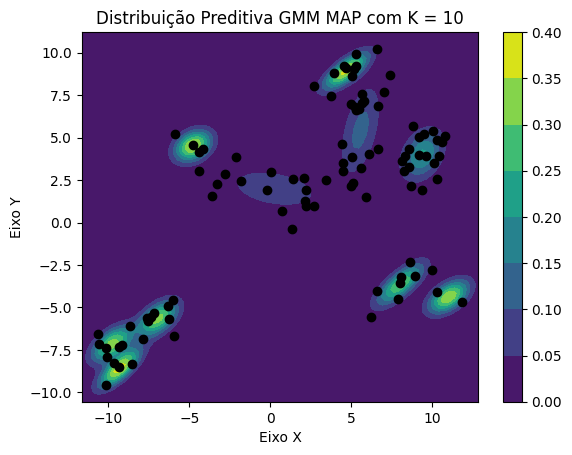

In [16]:
treino_e_resultados(df1, 10)